# Introduction
## What we are trying to accomplish
In general we are trying to provide answers to the following questions:
- How is the adoption of renewable energy in Europe evolving?
- How is the adoption of different types of renewable energy evolving?
- Are there characteristics of countries that correlate with their level of adoption of renewable energy?

### Main Questions
As these questions are defined very broadly and can be answered in a variety of ways, we decided to formulate the following more discreet questions, focusing on the production and consumption of renewable energy in europe:
- How has the adoption of renewable energy in Europe developed over time?
- Which types of renewable energy have been predominantly adopted?

### Sub Questions
- How do economic factors like GDP influence the adoption of renewable energy?


## Data Description
We are using the dataset from [Kaggle](https://www.kaggle.com/datasets/programmerrdai/renewable-energy/data). The general description can be found at the original [ourworldindata.org](https://ourworldindata.org/grapher/installed-solar-pv-capacity#:~:text=IRENA%20%E2%80%93%20Renewable%20Capacity-,Statistics) description.
**Absolute Values:** Absolute measurements are represented in megawatts (MW) rounded to the nearest one megawatt, with figures between zero and 0.5MW shown as a 0.
**Shares:** Shares are represented as percentages

## Exploring the data
Load all required packages and modules

In [94]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The dataset contains a wide range of data from different countries and time ranges. In this exercise we chose to only consider **european** countries and compare them to the overall european and global trends. We take the **years (1990-2020)** into consideration to answer our questions.

In [95]:
# ISO codes for European countries
country_codes = (
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA',
    'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT',
    'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'GBR')
entities = ('Europe', 'World')
time_window = (1990, 2020)

We clean the data by:
- Handling all NaN by dropping them
- Removing all non-European countries
- Only consider our targeted time window (1990-2020)

In [96]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    #df = df.dropna()

    # Only Use European Countries & Europe/World accumulated data
    df = df[(df['Code'].isin(country_codes)) | (df['Entity'].isin(entities))]
    #df = df[(df['Entity'] == 'Europe')]

    # Only consider data from (1990-2020)
    if 'Year' in df.columns:
        df.loc[:, 'Year'] = pd.to_numeric(df['Year'], errors='coerce')
        df = df[(df['Year'] >= time_window[0]) & (df['Year'] <= time_window[1])]

    df.reset_index(drop=True, inplace=True)

    return df

Put it all together and read and clean the dataframes:

In [97]:
def read_and_clean_csv(file) -> pd.DataFrame:
    df = pd.read_csv(file)
    df = clean_df(df)
    return df

folder_path = os.path.join('..', 'data')
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

dataframes = {os.path.basename(file).split('.')[0]: clean_df(read_and_clean_csv(file)) for file in csv_files}

### Merge semantically relevant dataframes
Now we merge dataframes that contain semantically relevant data into one. These are:
- `share_energy:` merged from `hydro-share-energy`,`solar-share-energy`,`wind-share-energy`,`renewable-share-energy`
- `share_electricity:` merged from `share-electricity-hydro`,`share-electricity-solar`,`share-electricity-solar`,`share-electricity-wind`,`share-electricity-renewables`



In [98]:
share_energy_keys = [key for key in dataframes.keys() if 'share-energy' in key]
share_energy_long = dataframes[share_energy_keys[0]]
for key in share_energy_keys[1:]:
    share_energy_long = share_energy_long.merge(
        dataframes[key],
        on=['Entity', 'Code', 'Year'],
        how='outer',
    )

share_electricity_keys = [key for key in dataframes.keys() if 'share-electricity' in key]
share_electricity_long = dataframes[share_electricity_keys[0]]
for key in share_electricity_keys[1:]:
    share_electricity_long = share_electricity_long.merge(
        dataframes[key],
        on=['Entity', 'Code', 'Year'],
        how='outer',
    )

### Multi-Index
These newly merged frames can now be converted from a long format to a wide multi-index dataformat.

In [99]:
share_energy = share_energy_long.set_index(['Entity', 'Year'])
share_electricity = share_electricity_long.set_index(['Entity', 'Year'])

### Check the Data

In [100]:
print("Merged 'share_energy' DataFrame:")
display(share_energy)

print("\nMerged 'share_electricity' DataFrame:")
display(share_electricity)

Merged 'share_energy' DataFrame:


Code  Hydro (% sub energy)  Renewables (% sub energy)  \
Entity  Year                                                              
Austria 1990       AUT                26.600                     27.586   
        1991       AUT                25.290                     26.299   
        1992       AUT                28.540                     29.655   
        1993       AUT                29.555                     30.682   
        1994       AUT                28.912                     29.914   
...                ...                   ...                        ...   
World   2016  OWID_WRL                 6.594                     10.239   
        2017  OWID_WRL                 6.515                     10.618   
        2018  OWID_WRL                 6.486                     10.978   
        2019  OWID_WRL                 6.481                     11.437   
        2020  OWID_WRL                 6.856                     12.553   

              Solar (% sub energy)  Wind (% sub energy)  
Entity  Year                                             
Austria 1990                 0.000                0.000  
        1991                 0.000                0.000  
        1992                 0.000                0.000  
        1993                 0.001                0.000  
        1994                 0.001                0.000  
...                            ...                  ...  
World   2016                 0.539                1.579  
        2017                 0.715                1.827  
        2018                 0.896                1.972  
        2019                 1.085                2.174  
        2020                 1.365                2.539  

[992 rows x 5 columns]


Merged 'share_electricity' DataFrame:


Code  Hydro (% electricity)  Renewables (% electricity)  \
Entity  Year                                                                
Austria 1990       AUT                 63.915                      66.207   
        1991       AUT                 62.654                      65.066   
        1992       AUT                 69.770                      72.392   
        1993       AUT                 71.462                      74.070   
        1994       AUT                 68.528                      70.812   
...                ...                    ...                         ...   
World   2016  OWID_WRL                 16.531                      24.256   
        2017  OWID_WRL                 16.277                      25.076   
        2018  OWID_WRL                 16.129                      25.763   
        2019  OWID_WRL                 16.048                      26.711   
        2020  OWID_WRL                 16.516                      28.522   

              Solar (% electricity)  Wind (% electricity)  
Entity  Year                                               
Austria 1990                  0.000                 0.000  
        1991                  0.000                 0.000  
        1992                  0.000                 0.000  
        1993                  0.000                 0.000  
        1994                  0.000                 0.000  
...                             ...                   ...  
World   2016                  1.358                 3.965  
        2017                  1.782                 4.570  
        2018                  2.196                 4.906  
        2019                  2.642                 5.401  
        2020                  3.197                 6.079  

[1023 rows x 5 columns]

### Noticing Trends
Now let's create some plots in order to better observe certain trends

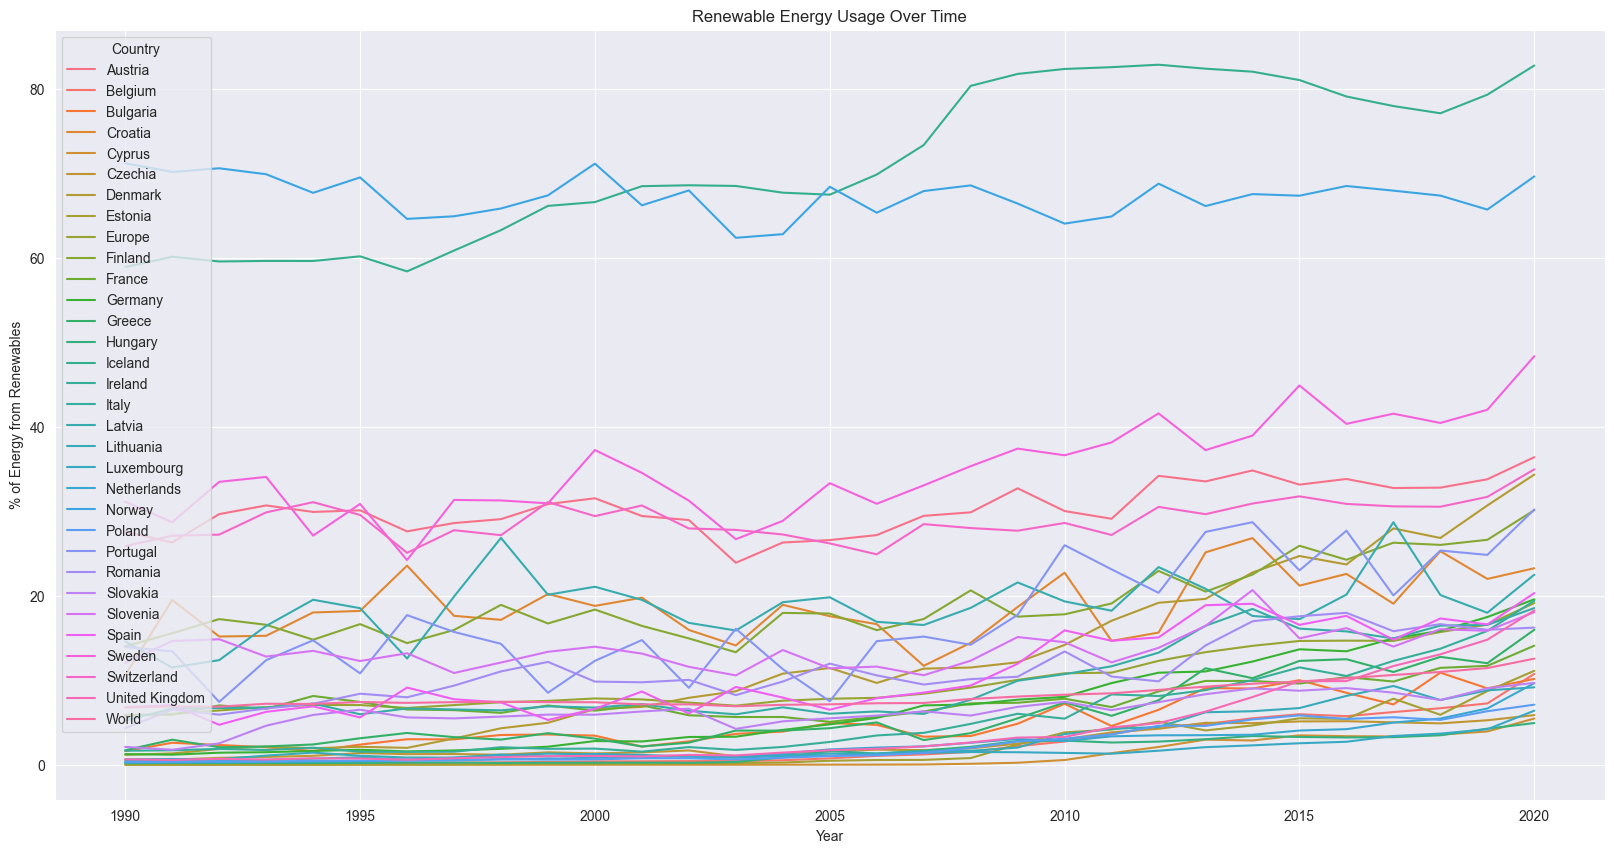

In [101]:
# Filter data for specific countries
countries = ['Austria', 'United Kingdom']
data_filtered = share_energy.loc[:]

# Reset index to make Year a column for plotting
data_filtered = data_filtered.reset_index()

# Plot renewables over time for selected countries
plt.figure(figsize=(20, 10))
sns.lineplot(data=data_filtered, x='Year', y='Renewables (% sub energy)', hue='Entity')
plt.title('Renewable Energy Usage Over Time')
plt.ylabel('% of Energy from Renewables')
plt.xlabel('Year')
plt.legend(title='Country')
plt.grid(True)
plt.show()

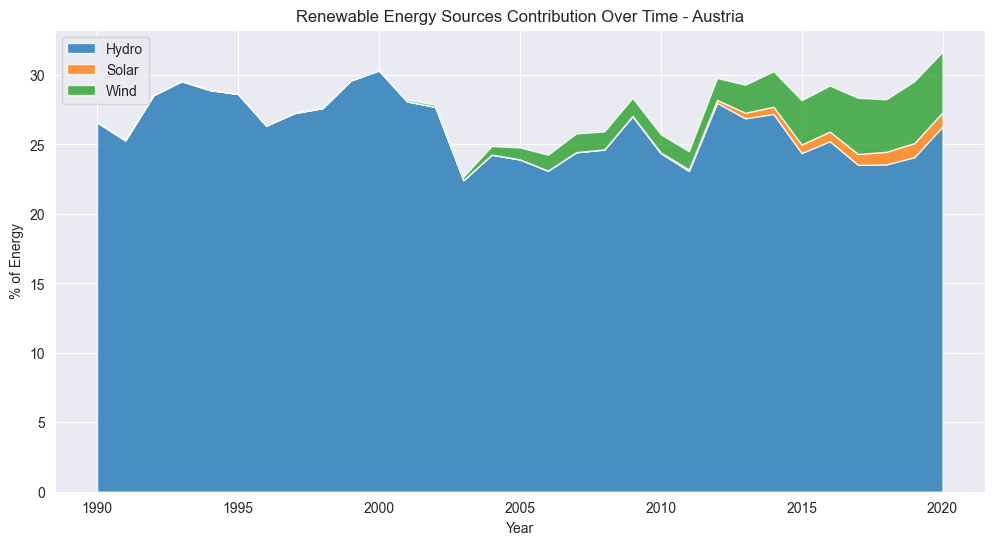

In [102]:
# Select a single country for the area plot
country = 'Austria'
data_country = share_energy.loc[country].reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.stackplot(
    data_country['Year'],
    data_country['Hydro (% sub energy)'],
    data_country['Solar (% sub energy)'],
    data_country['Wind (% sub energy)'],
    labels=['Hydro', 'Solar', 'Wind'],
    alpha=0.8
)
plt.title(f'Renewable Energy Sources Contribution Over Time - {country}')
plt.xlabel('Year')
plt.ylabel('% of Energy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


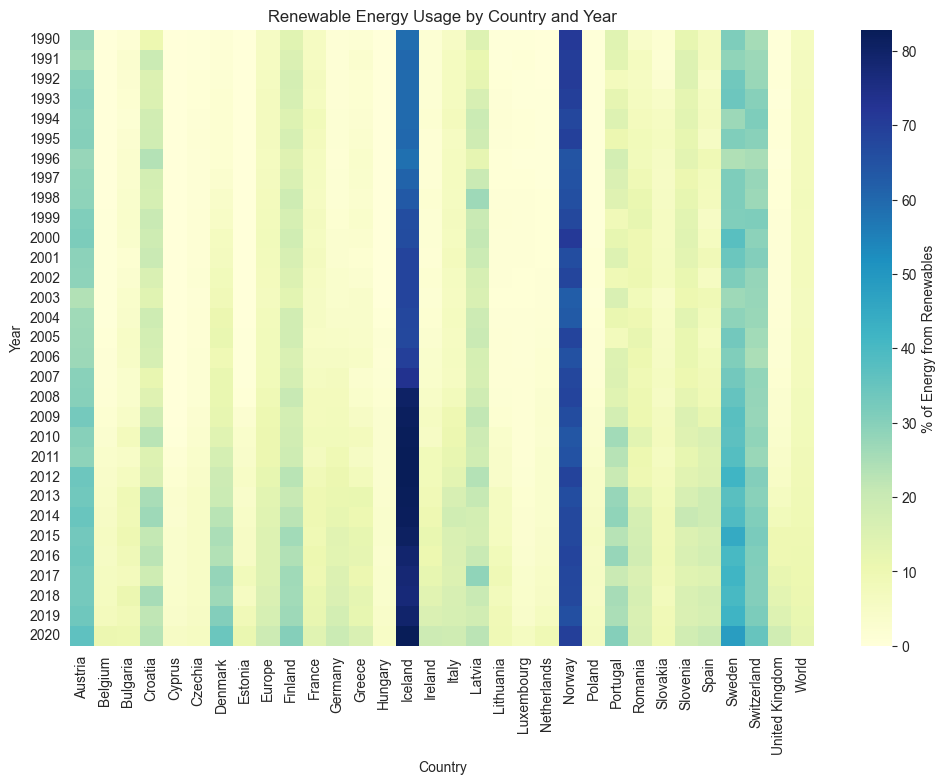

In [103]:
# Pivot table to make a heatmap-friendly format
heatmap_data = share_energy['Renewables (% sub energy)'].unstack(level=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': '% of Energy from Renewables'})
plt.title('Renewable Energy Usage by Country and Year')
plt.xlabel('Country')
plt.ylabel('Year')
plt.show()


C:\Users\elias\AppData\Local\Temp\ipykernel_251256\3804384107.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_year.index, y=data_year['Renewables (% sub energy)'], palette='viridis')


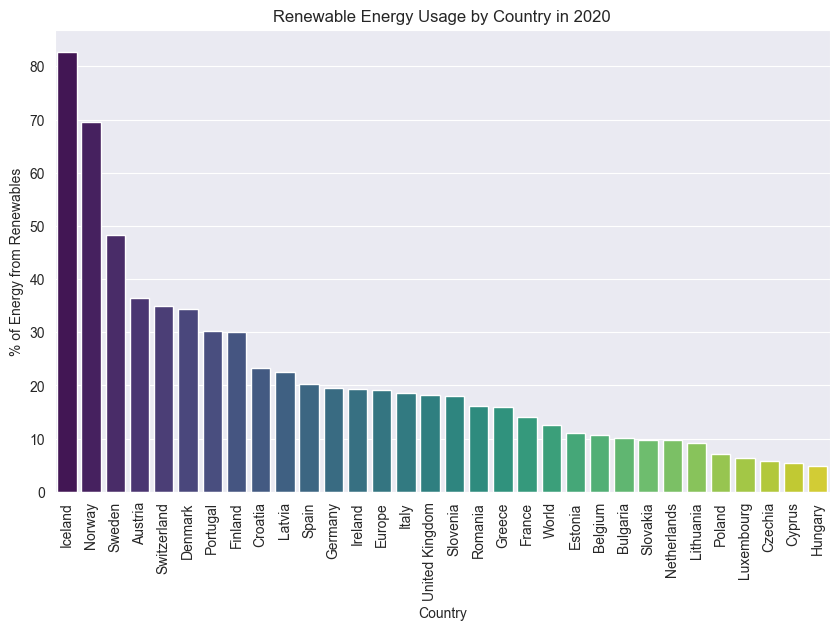

In [104]:
# Filter data for a specific year
year = 2020
data_year = share_energy.xs(key=year, level=1).sort_values(by='Renewables (% sub energy)', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=data_year.index, y=data_year['Renewables (% sub energy)'], palette='viridis')
plt.title(f'Renewable Energy Usage by Country in {year}')
plt.ylabel('% of Energy from Renewables')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()


In [105]:
# Optionally, print the cleaned data for verification
for key, df in dataframes.items():
    print(f'{key}:')
    print(df.head(), '\n')

biofuel-production:
    Entity Code  Year  Biofuels Production - TWh - Total
0  Austria  AUT  1990                           0.073269
1  Austria  AUT  1991                           0.080247
2  Austria  AUT  1992                           0.089551
3  Austria  AUT  1993                           0.101181
4  Austria  AUT  1994                           0.067454 

cumulative-installed-wind-energy-capacity-gigawatts:
    Entity Code  Year  Wind Capacity
0  Austria  AUT  1997          0.020
1  Austria  AUT  1998          0.030
2  Austria  AUT  1999          0.042
3  Austria  AUT  2000          0.050
4  Austria  AUT  2001          0.067 

hydro-share-energy:
    Entity Code  Year  Hydro (% sub energy)
0  Austria  AUT  1990                26.600
1  Austria  AUT  1991                25.290
2  Austria  AUT  1992                28.540
3  Austria  AUT  1993                29.555
4  Austria  AUT  1994                28.912 

hydropower-consumption:
    Entity Code  Year  Electricity from hydro (TW